In [2]:
!pip install gym[box2d]
!pip install gym[atari]
!pip install gym[classic_control]
!pip install gym[accept-rom-license]
!pip install ale_py
!pip install pygame 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.1 MB 5.3 MB/s 
     |████████████████████████████████| 18.3 MB 1.3 MB/s 
     |████████████████████████████████| 1.8 MB 20.0 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.6 MB 5.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for AutoROM.accept-rom-license: filename=AutoROM.accept_rom_license-0.4.2-py3-none-any.whl size=441027 sha256=fc415b25fe452e96a2f213b06af8b9bc2210fde932f868738ff802cfc6a76584
  Stored in directory: /root/.cache/pip/wheels/87/67/2e/6

In [3]:
import gym
import random
import torch
from matplotlib import pyplot as plt
import numpy as np
import copy
from collections import deque
import torch.nn.functional as F
from torch.autograd import Variable
from torch.distributions import Categorical
import os
os.environ['SDL_VIDEODRIVER']='dummy'
import pygame
pygame.display.set_mode((640,480))

<Surface(640x480x32 SW)>

##Random agent function

In [4]:
def randomGame(env, episodes):
    random_reward_array = []
    for episode in range(episodes):
        env.reset()
        done = False
        total = 0
        while not done:
            # Sample random actions
            action = env.action_space.sample()
            # Take action and extract results
            next_state, reward, done, info = env.step(action)
            # Update reward
            total += reward
            if done:
                break
        random_reward_array.append(total)
        #print('Episode : {}, score : {}'.format(episode, total))
    #print(list(range(episodes)))
    #print(random_reward_array)
    plt.plot(list(range(episodes)), random_reward_array, '-go')
    plt.xlabel('episodes')
    plt.ylabel('total reward')
    #plt.legend()
    plt.show()

#Problem 1

### Problem 1 part a
### Mountain Car environment loading 

In [4]:
env1 = gym.make('MountainCar-v0', render_mode='human')
#print(env1.reset())
#episodes = 1000
print(env1.observation_space.shape)
print(env1.action_space)

(2,)
Discrete(3)


/usr/local/lib/python3.7/dist-packages/gym/core.py:318: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."
/usr/local/lib/python3.7/dist-packages/gym/wrappers/step_api_compatibility.py:40: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."


#### Random agent used on mountain car to see reward function nature

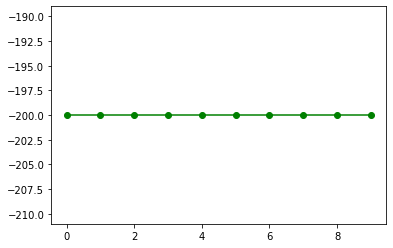

In [36]:
randomGame(env1, 10)

Reward function on random agent is giving constant reward over all the episodes

## problem 1 part b
#### Neural network code and Qnetwork class for both Mountain Car and Pong environment 

In [5]:
def getReward(state):
    if state[0] >= 0.5:
        print("Goal has been reached.")
        return 10
    if state[0] > -0.4:
        return (1+state[0])**2
    return 0

class qNetwork(torch.nn.Module):
    def __init__(self, input_size, output_size, n_hidden_states):
        super(qNetwork, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.n_hidden_states = n_hidden_states
        
        self.fc1 = torch.nn.Linear(input_size, n_hidden_states, 'relu')
        self.fc2 = torch.nn.Linear(n_hidden_states, output_size, 'linear')
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        y = self.fc2(x)
        return y
    
class qNetworkPong(torch.nn.Module):
    def __init__(self, in_channels=3, n_actions=14):
        super(qNetworkPong, self).__init__()
        self.conv1 = torch.nn.Conv2d(in_channels, 32, kernel_size=8, stride=4)
        # self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = torch.nn.Conv2d(32, 64, kernel_size=4, stride=2)
        # self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = torch.nn.Conv2d(64, 64, kernel_size=3, stride=1)
        # self.bn3 = nn.BatchNorm2d(64)
        self.fc4 = torch.nn.Linear(16*22*64, 512)
        self.head = torch.nn.Linear(512, n_actions)
        
    def forward(self, x):
        x = x.float() / 255
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.fc4(x.view(x.size(0), -1)))
        return self.head(x)

In [6]:
class deepQNetwork:
    
    def __init__(self, env, game, gamma = 0.95, epsilon = 1.0, lr = 0.001, eps_decay = 0.995, batch_size = 64, buffer_size = 100000):
        self.env = env
        self.action_space = env.action_space
        self.state_space = env.observation_space
        self.epsilon = epsilon
        self.gamma = gamma
        self.batch_size = batch_size
        self.epsilon_min = .01
        self.lr = lr
        self.epsilon_decay = eps_decay
        self.update_target_step = 500
        num_hidden_state = 64
        self.step_counter = 0
        self.game = game
        if game == "MountainCar-v0":
            self.model = qNetwork(self.state_space.shape[0], self.action_space.n, num_hidden_state)
        elif game == "ALE/Pong-v5":
            self.model = qNetworkPong(n_actions = self.action_space.n)
        self.target_model = copy.deepcopy(self.model)
        self.optimizer = torch.optim.Adam(self.model.parameters(),lr=0.001)
        self.replay_buffer = deque(maxlen=buffer_size)        
    
    def chooseAction(self, Q):
        if np.random.rand() < self.epsilon:
            return random.randrange(self.action_space.n)
        #print("state : ", state)
        return torch.argmax(Q, dim=1).item()
    
    def getState(self, obs):
        state = np.array(obs)
        state = state.transpose((2, 0, 1))
        state = torch.from_numpy(state)
        return state.unsqueeze(0)
    
    def store(self, state, action, reward, next_state, done):
        self.replay_buffer.append((state, action, reward, next_state, done))
        
    def train(self, episodes):
        rewards_array = []
        loss_array = []
        #agent = DQN(env.action_space.n, env.observation_space.shape[0])
        for e in range(episodes):
            if self.game == "MountainCar-v0":
                state = self.env.reset()
                state = torch.Tensor(state).unsqueeze(0)
                #print("state 1 : ", state)
                score = 0
                total_loss = 0
                max_steps = 500
                for i in range(max_steps):
                    #print("Start of step : ", i)
                    Q = self.model(state)
                    action = self.chooseAction(Q)
                    self.env.render()
                    next_state, reward, done,  info = self.env.step(action)
                    reward = getReward(next_state)
                    score += reward
                    next_state = torch.Tensor(next_state).unsqueeze(0)
                    #print("next_state : ", next_state)
                    self.store(state, action, reward, next_state, done)
                    state = next_state
                    loss = self.update_model()
                    #print("loss: ", loss)
                    total_loss += loss
                    self.step_counter = self.step_counter + 1
                    if (self.step_counter > self.update_target_step):
                        self.target_model.load_state_dict(self.model.state_dict())
                        self.step_counter = 0
                        print('updated target model')
                    if done:
                        print("episode: {}/{}, step: {}, score: {}".format(e+1, episodes, i, score))
                        break
                    #print("End of step : ", i)
                print("Reward for episode {}: {}, loss : {}".format(e+1, score, total_loss/max_steps))
                rewards_array.append(score)
                loss_array.append(total_loss/max_steps)
            elif self.game == "ALE/Pong-v5":
                state = self.env.reset()
                #print("before state : ", state )
                state = self.getState(state)
                #print("after get state : ", state, state.shape)
                #print("state 1 : ", state)
                score = 0
                total_loss = 0
                max_steps = 2000
                for i in range(max_steps):
                    #print("Start of step : ", i)
                    Q = self.model(state)
                    action = self.chooseAction(Q)
                    #self.env.render()
                    next_state, reward, done, info = self.env.step(action)
                    #print("rewards : ", reward)
                    #print("done : ", done)
                    #print("next_state  : ", next_state)
                    next_state = self.getState(next_state)
                    score += reward
                    #print("next_state : ", next_state)
                    self.store(state, action, reward, next_state, done)
                    state = next_state
                    loss = self.update_model()
                    #print("loss: ", loss)
                    total_loss += loss
                    self.step_counter = self.step_counter + 1
                    if (self.step_counter > self.update_target_step):
                        self.target_model.load_state_dict(self.model.state_dict())
                        self.step_counter = 0
                        print('updated target model')
                    if done:
                        print("episode: {}/{}, step: {}, score: {}".format(e+1, episodes, i, score))
                        break
                    #print("End of step : ", i)
                print("Reward for episode {}: {}, loss : {}".format(e+1, score, total_loss/max_steps))
                rewards_array.append(score)
                loss_array.append(total_loss/max_steps)
        return rewards_array, loss_array, self.replay_buffer
    
    def update_model(self):
        if len(self.replay_buffer) < self.batch_size:
            return 0
        
        if self.game == "MountainCar-v0":
            self.optimizer.zero_grad()
            minibatch = random.sample(self.replay_buffer, self.batch_size)
            #print("minibatch: ", minibatch)
            states = torch.tensor(np.squeeze(np.array([i[0].numpy() for i in minibatch])), dtype=torch.float)
            actions = torch.tensor(np.array([i[1] for i in minibatch]), dtype=torch.long).view(self.batch_size, -1)
            rewards = torch.tensor(np.array([i[2] for i in minibatch]), dtype=torch.float).view(self.batch_size, -1)
            next_states = torch.tensor(np.squeeze(np.array([i[3].numpy() for i in minibatch])), dtype=torch.float)
            dones = torch.tensor(np.array([i[4] for i in minibatch]), dtype=torch.float)

            #print("states : ", states)
            #print("actions : ", actions)
            #print("rewards : ", rewards)
            #print("next_states : ", torch.tensor(next_states))
            #print("dones : ", dones)

            target_q = rewards + self.gamma*self.target_model(next_states).max(dim=1)[0].detach()*(1 - dones)
            policy_q = self.model(states).gather(1,actions)
            L = F.smooth_l1_loss(policy_q.squeeze(),target_q.squeeze())
            L.backward()
            #print("L : ", L)
            self.optimizer.step()
            if self.epsilon > self.epsilon_min:
                self.epsilon *= self.epsilon_decay
            return L.detach().item()
        elif self.game == "ALE/Pong-v5":
            
            self.optimizer.zero_grad()
            minibatch = random.sample(self.replay_buffer, self.batch_size)
            #print("minibatch: ", minibatch)
            states = torch.tensor(np.squeeze(np.array([i[0].numpy() for i in minibatch])), dtype=torch.float)
            actions = torch.tensor(np.array([i[1] for i in minibatch]), dtype=torch.long).view(self.batch_size, -1)
            rewards = torch.tensor(np.array([i[2] for i in minibatch]), dtype=torch.float).view(self.batch_size, -1)
            next_states = torch.tensor(np.squeeze(np.array([i[3].numpy() for i in minibatch])), dtype=torch.float)
            dones = torch.tensor(np.array([i[4] for i in minibatch]), dtype=torch.float)

            #print("states : ", states)
            #print("actions : ", actions)
            #print("rewards : ", rewards)
            #print("next_states : ", torch.tensor(next_states))
            #print("dones : ", dones)

            target_q = rewards + self.gamma*self.target_model(next_states).max(dim=1)[0].detach()*(1 - dones)
            policy_q = self.model(states).gather(1,actions)
            L = F.smooth_l1_loss(policy_q.squeeze(),target_q.squeeze())
            L.backward()
            #print("L : ", L)
            self.optimizer.step()
            if self.epsilon > self.epsilon_min:
                self.epsilon *= self.epsilon_decay
            return L.detach().item()


#### DQN applied on Mountain Car environment 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:142: UserWarning: Using a target size (torch.Size([64, 64])) that is different to the input size (torch.Size([64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


episode: 1/400, step: 199, score: 12.043310367027733
Reward for episode 1: 12.043310367027733, loss : 0.0025491038088221105
episode: 2/400, step: 199, score: 0
Reward for episode 2: 0, loss : 0.0030430796686559914
updated target model
episode: 3/400, step: 199, score: 8.28777448340924
Reward for episode 3: 8.28777448340924, loss : 0.0020161188011988997
episode: 4/400, step: 199, score: 12.817161376969871
Reward for episode 4: 12.817161376969871, loss : 0.002603819637326524
episode: 5/400, step: 199, score: 0
Reward for episode 5: 0, loss : 0.0026453846371732653
updated target model
episode: 6/400, step: 199, score: 29.55119567896196
Reward for episode 6: 29.55119567896196, loss : 0.002859571134787984
episode: 7/400, step: 199, score: 37.716689373405295
Reward for episode 7: 37.716689373405295, loss : 0.004924136405810714
updated target model
episode: 8/400, step: 199, score: 54.96860087207728
Reward for episode 8: 54.96860087207728, loss : 0.007380007362924516
episode: 9/400, step: 199

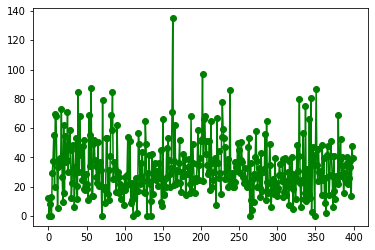

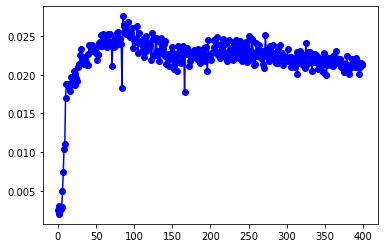

In [43]:
agent = deepQNetwork(env1, "MountainCar-v0")
rewards_array, loss_array, buffer = agent.train(400)
plt.plot(range(len(rewards_array)), rewards_array, '-go')
plt.show()
plt.plot(range(len(loss_array)), loss_array, '-bo')
plt.show()

#### Plot for different actions over velocity and position for mountain Car

(tensor([[-0.4103,  0.0000]]), 2, 0, tensor([[-4.1018e-01,  1.6683e-04]]), False)


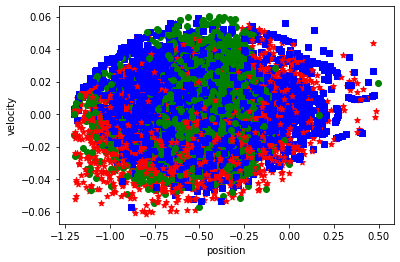

In [57]:
print(buffer[0])
for element in random.sample(buffer, 20000):
  if element[1] == 0:
    plt.scatter(element[0][0][0], element[0][0][1], color = 'r', marker='*', label='move left')
  elif element[1] == 1:
    plt.scatter(element[0][0][0], element[0][0][1], color = 'g', marker='o', label='donot move')
  elif element[1] == 2:
    plt.scatter(element[0][0][0], element[0][0][1], color = 'b', marker='s', label='move right')
plt.ylabel('velocity')
plt.xlabel('position')
plt.show()

red - move left

green - donot move

blue - move right

### Problem 1 part c
#### Plots for reward over episodes for different batch sizes of minibatches used for Mountain Car problem

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:141: UserWarning: Using a target size (torch.Size([32, 32])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


episode: 1/150, step: 199, score: 24.217230517260788
Reward for episode 1: 24.217230517260788, loss : 0.002982649534853408
episode: 2/150, step: 199, score: 0
Reward for episode 2: 0, loss : 0.006641268379986286
updated target model
episode: 3/150, step: 199, score: 11.244792376916358
Reward for episode 3: 11.244792376916358, loss : 0.004637646673014388
episode: 4/150, step: 199, score: 11.784881275897817
Reward for episode 4: 11.784881275897817, loss : 0.004369045683240984
episode: 5/150, step: 199, score: 19.5224379023915
Reward for episode 5: 19.5224379023915, loss : 0.0046501396892126646
updated target model
episode: 6/150, step: 199, score: 21.07161897900832
Reward for episode 6: 21.07161897900832, loss : 0.004562216314952821
episode: 7/150, step: 199, score: 2.93285652467942
Reward for episode 7: 2.93285652467942, loss : 0.005044179821852595
updated target model
episode: 8/150, step: 199, score: 3.400780192402536
Reward for episode 8: 3.400780192402536, loss : 0.00433150452666450

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:141: UserWarning: Using a target size (torch.Size([128, 128])) that is different to the input size (torch.Size([128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


episode: 1/150, step: 199, score: 0
Reward for episode 1: 0, loss : 0.0028925213181937577
episode: 2/150, step: 199, score: 13.452928968389578
Reward for episode 2: 13.452928968389578, loss : 0.0014582431146263842
updated target model
episode: 3/150, step: 199, score: 25.69734184331487
Reward for episode 3: 25.69734184331487, loss : 0.0036814215551130474
episode: 4/150, step: 199, score: 0
Reward for episode 4: 0, loss : 0.0045651335138827565
episode: 5/150, step: 199, score: 0
Reward for episode 5: 0, loss : 0.003672067204490304
updated target model
episode: 6/150, step: 199, score: 15.71932060652021
Reward for episode 6: 15.71932060652021, loss : 0.003422880616504699
episode: 7/150, step: 199, score: 17.95245948173697
Reward for episode 7: 17.95245948173697, loss : 0.003930112216621638
updated target model
episode: 8/150, step: 199, score: 37.10482818992124
Reward for episode 8: 37.10482818992124, loss : 0.005004117613658309
episode: 9/150, step: 199, score: 12.448088504620596
Reward

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:141: UserWarning: Using a target size (torch.Size([256, 256])) that is different to the input size (torch.Size([256])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


episode: 2/150, step: 199, score: 12.667744435104233
Reward for episode 2: 12.667744435104233, loss : 0.002401919822907075
updated target model
episode: 3/150, step: 199, score: 34.84088634447731
Reward for episode 3: 34.84088634447731, loss : 0.003766536549665034
episode: 4/150, step: 199, score: 8.018636274511046
Reward for episode 4: 8.018636274511046, loss : 0.006292408801615238
episode: 5/150, step: 199, score: 0
Reward for episode 5: 0, loss : 0.0052866703011095525
updated target model
episode: 6/150, step: 199, score: 4.216445385193977
Reward for episode 6: 4.216445385193977, loss : 0.0047673676498234275
episode: 7/150, step: 199, score: 0
Reward for episode 7: 0, loss : 0.004099244831129909
updated target model
episode: 8/150, step: 199, score: 0
Reward for episode 8: 0, loss : 0.0036373576512560247
episode: 9/150, step: 199, score: 0
Reward for episode 9: 0, loss : 0.003176211402285844
episode: 10/150, step: 199, score: 0
Reward for episode 10: 0, loss : 0.0029262624816037714


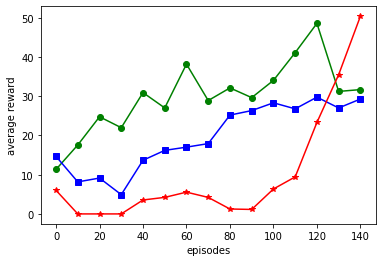

In [22]:
#different batch sizes for minibatch formation
points = []
for i in range(0, 150, 10):
  points.append(i)
for m, c in zip([32, 128, 256], ['-go', '-bs', '-r*']):
  agent = deepQNetwork(env1, "MountainCar-v0", batch_size = m)
  rewards_array, loss_array, buffer = agent.train(150)
  rewards_points = []
  sum = 0
  for i in range(len(rewards_array)):
    sum += rewards_array[i]
    if (i+1)%10 == 0:
      rewards_points.append(sum/10)
      sum = 0
  plt.plot(points, rewards_points, c, label=m)
plt.xlabel('episodes')
plt.ylabel('average reward')
plt.show()

### Problem 1 part a
#### Pong environment loading

In [6]:
env2 = gym.make("ALE/Pong-v5", render_mode = "rgb_array")
print(env2.observation_space.shape)
print(env2.action_space)
#print(env2.reset())
#episodes = 1000

(210, 160, 3)
Discrete(6)


/usr/local/lib/python3.7/dist-packages/gym/core.py:318: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."
/usr/local/lib/python3.7/dist-packages/gym/wrappers/step_api_compatibility.py:40: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."


#### Random agent on Pong environment

/usr/local/lib/python3.7/dist-packages/gym/utils/passive_env_checker.py:228: DeprecationWarning: WARN: Core environment is written in old step API which returns one bool instead of two. It is recommended to rewrite the environment with new step API. 
  "Core environment is written in old step API which returns one bool instead of two. "


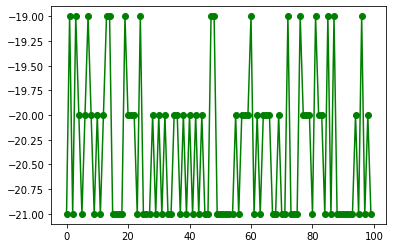

In [45]:
randomGame(env2, 100)

From above it seems the rewards are fluctuating between three values -19, -20 and -21

#### DQN implementation over Pong Environment 
##### Due to less time only 10 episodes were executed which took on google colab about 3-4 hours. This can be changed by changing the parameter which is number of episodes inside the agent.train() function. Due to lack of time in submitting this assignment and huge training time 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Using a target size (torch.Size([64, 64])) that is different to the input size (torch.Size([64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


updated target model
episode: 1/10, step: 764, score: -21.0
Reward for episode 1: -21.0, loss : 0.004133186613395083
updated target model
updated target model
episode: 2/10, step: 792, score: -21.0
Reward for episode 2: -21.0, loss : 0.005052552084341641
updated target model
episode: 3/10, step: 826, score: -21.0
Reward for episode 3: -21.0, loss : 0.0052786570797197785
updated target model
updated target model
episode: 4/10, step: 842, score: -20.0
Reward for episode 4: -20.0, loss : 0.005293281133397614
updated target model
updated target model
episode: 5/10, step: 887, score: -20.0
Reward for episode 5: -20.0, loss : 0.0053645493097692456
updated target model
updated target model
episode: 6/10, step: 907, score: -21.0
Reward for episode 6: -21.0, loss : 0.005697530581339379
updated target model
episode: 7/10, step: 888, score: -21.0
Reward for episode 7: -21.0, loss : 0.005468660998380073
updated target model
updated target model
episode: 8/10, step: 842, score: -21.0
Reward for epi

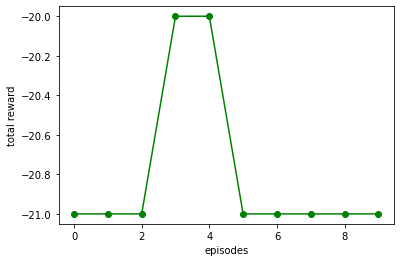

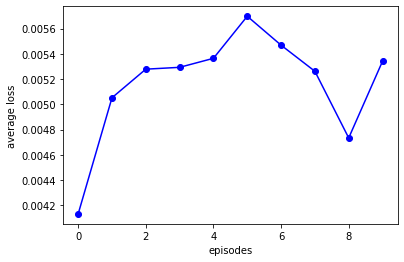

In [8]:
agent = deepQNetwork(env2, "ALE/Pong-v5")
rewards_array, loss_array, buffer = agent.train(10)
plt.plot(range(len(rewards_array)), rewards_array, '-go')
plt.xlabel('episodes')
plt.ylabel('total reward')
plt.show()
plt.plot(range(len(loss_array)), loss_array, '-bo')
plt.xlabel('episodes')
plt.ylabel('average loss')
plt.show()

### Problem 2 part b
#### Policy Gradient algo implementation

In [7]:
class policyNetwork(torch.nn.Module):
    def __init__(self, state_size=4, action_size=2, hidden_size=64):
        super(policyNetwork, self).__init__()
        self.fc1 = torch.nn.Linear(state_size, hidden_size)
        self.fc2 = torch.nn.Linear(hidden_size, action_size)
        
    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = self.fc2(x)
        # we just consider 1 dimensional probability of action
        return F.softmax(x, dim=1)

In [19]:
class Network:
    def __init__(self, env, game, reward_to_go_flag = False, normalizaton_function_flag = False, gamma = 0.95, epsilon = 1.0, batch_size = 500, buffer_size = 100, lr = 0.001):
        self.env = env
        self.action_space = env.action_space
        self.state_space = env.observation_space
        self.gamma = gamma
        self.batch_size = batch_size
        self.game = game
        self.lr = lr
        self.reward_to_go_flag = reward_to_go_flag
        self.normalizaton_function_flag = normalizaton_function_flag
        if game == "CartPole-v1":
            self.model = policyNetwork()
        elif game == "LunarLander-v2":
            self.model = policyNetwork(state_size = self.state_space.shape[0], action_size = self.action_space.n)
        self.optimizer = torch.optim.Adam(self.model.parameters(),lr=0.001)
        self.scores_list = deque(maxlen=buffer_size)
    
    def chooseAction(self, probs):
        c = Categorical(probs)
        action = c.sample()
        return action.item(), c.log_prob(action)
        
    def train(self, episodes):
        k = 200
        k_episode_score = []
        k_episode_avg = 0
        points = []
        rewards_array = []
        loss_array = []
        #agent = DQN(env.action_space.n, env.observation_space.shape[0])
        for e in range(episodes):
            if self.game == "CartPole-v1" :
                saved_log_probs = []
                rewards = []
                state = self.env.reset()
                state = torch.Tensor(state).unsqueeze(0)
                #print("state 1 : ", state)
                score = 0
                total_loss = 0
                max_steps = self.batch_size
                for i in range(max_steps):
                    #print("Start of step : ", i)
                    probs = self.model(state)
                    action, log_prob = self.chooseAction(probs)
                    saved_log_probs.append(log_prob)
                    next_state, reward, done, info = self.env.step(action)
                    score += reward
                    rewards.append(reward)
                    next_state = torch.Tensor(next_state).unsqueeze(0)
                    #print("next_state : ", next_state)
                    state = next_state
                    #print("loss: ", loss)
                    state = next_state
                    if done:
                        print("episode: {}/{}, step: {}, score: {}".format(e+1, episodes, i, score))
                        break
                    #print("End of step : ", i)
                total_loss = self.update(rewards, saved_log_probs)
                loss_array.append(total_loss)
                print("Reward for episode {}: {}, loss : {}".format(e+1, score, total_loss/max_steps))
                rewards_array.append(score)
                k_episode_avg += score
                if (e+1)%k == 0:
                    k_episode_score.append(k_episode_avg/k)
                    points.append(e+1)
                    k_episode_avg = 0
            elif self.game == "LunarLander-v2":
                saved_log_probs = []
                rewards = []
                state = self.env.reset()
                state = torch.Tensor(state).unsqueeze(0)
                #print("state 1 : ", state)
                score = 0
                total_loss = 0
                max_steps = self.batch_size
                for i in range(max_steps):
                    #print("Start of step : ", i)
                    probs = self.model(state)
                    action, log_prob = self.chooseAction(probs)
                    saved_log_probs.append(log_prob)
                    next_state, reward, done, info = self.env.step(action)
                    score += reward
                    rewards.append(reward)
                    next_state = torch.Tensor(next_state).unsqueeze(0)
                    #print("next_state : ", next_state)
                    state = next_state
                    #print("loss: ", loss)
                    state = next_state
                    if done:
                        print("episode: {}/{}, step: {}, score: {}".format(e+1, episodes, i, score))
                        break
                    #print("End of step : ", i)
                total_loss = self.update(rewards, saved_log_probs)
                loss_array.append(total_loss)
                print("Reward for episode {}: {}, loss : {}".format(e+1, score, total_loss/max_steps))
                rewards_array.append(score)
                k_episode_avg += score
                if (e+1)%k == 0:
                    k_episode_score.append(k_episode_avg/k)
                    points.append(e+1)
                    k_episode_avg = 0
        return rewards_array, k_episode_score, points, loss_array
    
    def update(self, rewards, saved_log_probs):
        # Recalculate the total reward applying discounted factor
        if self.reward_to_go_flag:
          discounts = [self.gamma ** i for i in range(len(rewards))]
          discounted_rewards = [a * b for a,b in zip(discounts, rewards)]
          saved_log_probs = saved_log_probs[1:len(saved_log_probs)]
        else:
          discounts = [self.gamma ** i for i in range(len(rewards) + 1)]
          discounted_rewards = [a * b for a,b in zip(discounts, rewards)]
        p = len(discounted_rewards)
        if self.normalizaton_function_flag:
          ordered_mean = []
          advantage_value = []
          for i in reversed(range(p)):
            G = sum(discounted_rewards[i:p])
            average_value = G/(p - i)
            ordered_mean.append(average_value)
            advantage_value.append(G - average_value)
        else:
          R = sum(discounted_rewards)
        # Calculate the loss 
        policy_loss = []
        i = p
        for log_prob in saved_log_probs:
            # Note that we are using Gradient Ascent, not Descent. So we need to calculate it with negative rewards.
            if self.normalizaton_function_flag:
              R = advantage_value[i - 1]
              i = i - 1
            policy_loss.append(-log_prob * R)
        # After that, we concatenate whole policy loss in 0th dimension
        policy_loss = torch.cat(policy_loss).sum()
        
        # Backpropagation
        self.optimizer.zero_grad()
        policy_loss.backward()
        self.optimizer.step()
        return policy_loss.detach().item()

#### Loading CartPole environment

In [9]:
env3 = gym.make('CartPole-v1', render_mode = "rgb_array")
print(env3.observation_space.shape)
print(env3.action_space)

(4,)
Discrete(2)


#### Running a random agent on Cartpole environment

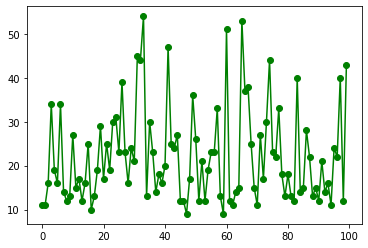

In [16]:
randomGame(env3, 100)

Random agent is taking random action for each step in each episode which gives random reward.

#### Running policy gradient algorthm without reward to go and normalization functionality on cartPole environment

Streaming output truncated to the last 5000 lines.
loss :  tensor(1635.7578, grad_fn=<SumBackward0>)
Reward for episode 3334: 146.0, loss : 0.0
episode: 3335/5000, step: 72, score: 73.0
loss :  tensor(829.5488, grad_fn=<SumBackward0>)
Reward for episode 3335: 73.0, loss : 0.0
episode: 3336/5000, step: 33, score: 34.0
loss :  tensor(332.0285, grad_fn=<SumBackward0>)
Reward for episode 3336: 34.0, loss : 0.0
episode: 3337/5000, step: 84, score: 85.0
loss :  tensor(963.6404, grad_fn=<SumBackward0>)
Reward for episode 3337: 85.0, loss : 0.0
episode: 3338/5000, step: 37, score: 38.0
loss :  tensor(367.0641, grad_fn=<SumBackward0>)
Reward for episode 3338: 38.0, loss : 0.0
episode: 3339/5000, step: 29, score: 30.0
loss :  tensor(284.9477, grad_fn=<SumBackward0>)
Reward for episode 3339: 30.0, loss : 0.0
episode: 3340/5000, step: 40, score: 41.0
loss :  tensor(430.7934, grad_fn=<SumBackward0>)
Reward for episode 3340: 41.0, loss : 0.0
episode: 3341/5000, step: 46, score: 47.0
loss :  tensor(4

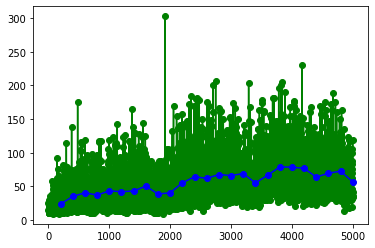

In [26]:
agent3 = Network(env3, "CartPole-v1")
rewards_array, k_episode_score, points, loss_array = agent3.train(5000)
plt.plot(range(len(rewards_array)), rewards_array, '-go')
plt.plot(points, k_episode_score, '-bo')
plt.xlabel('episodes')
plt.ylabel('total reward')
plt.show()

#### Running policy gradient algorthm with normalization functionality on cartPole environment

Streaming output truncated to the last 5000 lines.
episode: 2501/5000, step: 143, score: 144.0
Reward for episode 2501: 144.0, loss : 0.46167056274414064
episode: 2502/5000, step: 108, score: 109.0
Reward for episode 2502: 109.0, loss : 0.4086426696777344
episode: 2503/5000, step: 76, score: 77.0
Reward for episode 2503: 77.0, loss : 0.385979736328125
episode: 2504/5000, step: 62, score: 63.0
Reward for episode 2504: 63.0, loss : 0.3599634399414062
episode: 2505/5000, step: 82, score: 83.0
Reward for episode 2505: 83.0, loss : 0.37482113647460935
episode: 2506/5000, step: 147, score: 148.0
Reward for episode 2506: 148.0, loss : 0.4390283203125
episode: 2507/5000, step: 97, score: 98.0
Reward for episode 2507: 98.0, loss : 0.4849000244140625
episode: 2508/5000, step: 121, score: 122.0
Reward for episode 2508: 122.0, loss : 0.3989534912109375
episode: 2509/5000, step: 99, score: 100.0
Reward for episode 2509: 100.0, loss : 0.4753280029296875
episode: 2510/5000, step: 82, score: 83.0
Rewa

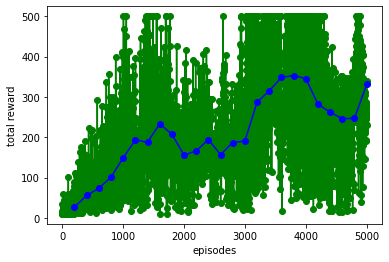

In [13]:
agent3 = Network(env3, "CartPole-v1", normalizaton_function_flag = True)
rewards_array, k_episode_score, points, loss_array = agent3.train(5000)
plt.plot(range(len(rewards_array)), rewards_array, '-go')
plt.plot(points, k_episode_score, '-bo')
plt.xlabel('episodes')
plt.ylabel('total reward')
plt.show()

#### Running policy gradient algorthm with reward to go functionality on cartPole environment

Streaming output truncated to the last 5000 lines.
episode: 2501/5000, step: 28, score: 29.0
Reward for episode 2501: 29.0, loss : 0.5298388671875
episode: 2502/5000, step: 22, score: 23.0
Reward for episode 2502: 23.0, loss : 0.42405255126953123
episode: 2503/5000, step: 19, score: 20.0
Reward for episode 2503: 20.0, loss : 0.3078587341308594
episode: 2504/5000, step: 63, score: 64.0
Reward for episode 2504: 64.0, loss : 1.3363541259765626
episode: 2505/5000, step: 33, score: 34.0
Reward for episode 2505: 34.0, loss : 0.5337108764648437
episode: 2506/5000, step: 54, score: 55.0
Reward for episode 2506: 55.0, loss : 1.0097908935546875
episode: 2507/5000, step: 95, score: 96.0
Reward for episode 2507: 96.0, loss : 2.1024375
episode: 2508/5000, step: 46, score: 47.0
Reward for episode 2508: 47.0, loss : 0.8390490112304687
episode: 2509/5000, step: 55, score: 56.0
Reward for episode 2509: 56.0, loss : 0.9264341430664063
episode: 2510/5000, step: 60, score: 61.0
Reward for episode 2510: 61

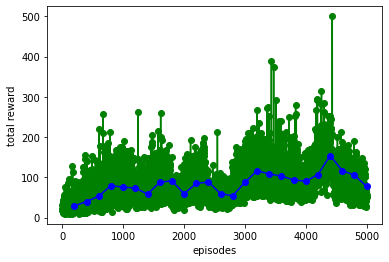

In [20]:
agent3 = Network(env3, "CartPole-v1", reward_to_go_flag = True)
rewards_array, k_episode_score, points, loss_array = agent3.train(5000)
plt.plot(range(len(rewards_array)), rewards_array, '-go')
plt.plot(points, k_episode_score, '-bo')
plt.xlabel('episodes')
plt.ylabel('total reward')
plt.show()

#### loading LunarLander Envronment

In [15]:
env4 = gym.make(
    "LunarLander-v2",
    continuous= False,
    gravity = -10.0,
    enable_wind = False,
    wind_power = 15.0,
    turbulence_power = 1.5,
)

print(env4.observation_space)
print(env4.action_space)

Box([-1.5       -1.5       -5.        -5.        -3.1415927 -5.
 -0.        -0.       ], [1.5       1.5       5.        5.        3.1415927 5.        1.
 1.       ], (8,), float32)
Discrete(4)


#### Running random agent on lunar lander environment

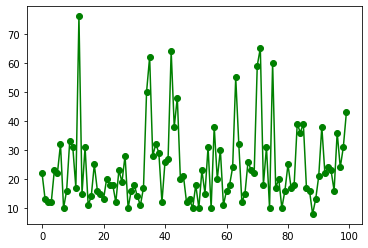

In [21]:
randomGame(env3, 100)

Random agent is taking random action for each step in each episode which gives random reward.

#### Running policy gradient algorthm without reward to go and normalization functionality on LunarLander environment

Streaming output truncated to the last 5000 lines.
loss :  tensor(502.0682, grad_fn=<SumBackward0>)
Reward for episode 3298: -120.77391331725619, loss : 0.0
episode: 3299/5000, step: 141, score: -270.8231298227379
loss :  tensor(-136.7418, grad_fn=<SumBackward0>)
Reward for episode 3299: -270.8231298227379, loss : 0.0
episode: 3300/5000, step: 146, score: -203.09991953579475
loss :  tensor(2355.4531, grad_fn=<SumBackward0>)
Reward for episode 3300: -203.09991953579475, loss : 0.0
episode: 3301/5000, step: 177, score: -11.5555118224123
loss :  tensor(-455.6854, grad_fn=<SumBackward0>)
Reward for episode 3301: -11.5555118224123, loss : 0.0
episode: 3302/5000, step: 172, score: -326.07331583595396
loss :  tensor(-2772.2878, grad_fn=<SumBackward0>)
Reward for episode 3302: -326.07331583595396, loss : 0.0
episode: 3303/5000, step: 141, score: -47.736690471968906
loss :  tensor(-636.9951, grad_fn=<SumBackward0>)
Reward for episode 3303: -47.736690471968906, loss : 0.0
episode: 3304/5000, ste

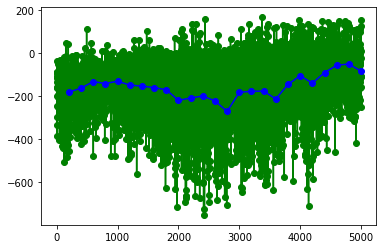

In [27]:
agent4 = Network(env4, "LunarLander-v2")
rewards_array, k_episode_score, points, loss_array = agent4.train(5000)
plt.plot(range(len(rewards_array)), rewards_array, '-go')
plt.plot(points, k_episode_score, '-bo')
plt.xlabel('episodes')
plt.ylabel('total reward')
plt.show()

### Problem 2 part c
#### Running Lunarlander on different batchsizes

episode: 1/3000, step: 65, score: -102.2546332752063
Reward for episode 1: -102.2546332752063, loss : -14.03890380859375
episode: 2/3000, step: 84, score: -268.06654196925524
Reward for episode 2: -268.06654196925524, loss : -21.6228662109375
episode: 3/3000, step: 82, score: -148.5341330063127
Reward for episode 3: -148.5341330063127, loss : -26.17709228515625
episode: 4/3000, step: 96, score: -272.08159096202223
Reward for episode 4: -272.08159096202223, loss : -23.615947265625
Reward for episode 5: -403.03274986735255, loss : -49.205048828125
episode: 6/3000, step: 90, score: -434.03788167519303
Reward for episode 6: -434.03788167519303, loss : -48.130341796875
Reward for episode 7: -195.8167351554653, loss : -14.849503173828126
Reward for episode 8: -131.71049884655645, loss : -22.72417236328125
Reward for episode 9: -13.549519802853329, loss : -14.5195947265625
episode: 10/3000, step: 71, score: -81.21109221750112
Reward for episode 10: -81.21109221750112, loss : -6.96545288085937

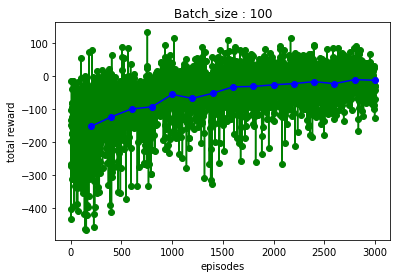

Streaming output truncated to the last 5000 lines.
Reward for episode 496: -131.23777395152032, loss : -7.152605794270833
episode: 497/3000, step: 84, score: -93.38775327741828
Reward for episode 497: -93.38775327741828, loss : -6.3927620442708335
episode: 498/3000, step: 114, score: -140.03975573167935
Reward for episode 498: -140.03975573167935, loss : -5.966268310546875
episode: 499/3000, step: 60, score: -69.74997115790562
Reward for episode 499: -69.74997115790562, loss : -1.4367538452148438
episode: 500/3000, step: 86, score: -331.3243712954227
Reward for episode 500: -331.3243712954227, loss : -14.198846028645834
episode: 501/3000, step: 63, score: -101.41899392075517
Reward for episode 501: -101.41899392075517, loss : -4.693132731119792
episode: 502/3000, step: 72, score: -104.77479207514995
Reward for episode 502: -104.77479207514995, loss : -2.1924420166015626
episode: 503/3000, step: 56, score: -102.37890111370483
Reward for episode 503: -102.37890111370483, loss : -2.075380

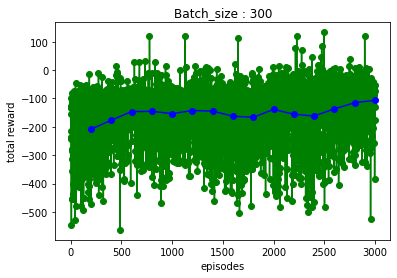

Streaming output truncated to the last 5000 lines.
Reward for episode 496: -129.41117136616998, loss : -1.6813302612304688
episode: 497/3000, step: 87, score: -25.99458891890393
Reward for episode 497: -25.99458891890393, loss : -3.7052006022135417
episode: 498/3000, step: 109, score: -178.004158579501
Reward for episode 498: -178.004158579501, loss : -2.81680419921875
episode: 499/3000, step: 104, score: -272.6440805010761
Reward for episode 499: -272.6440805010761, loss : -3.2501470947265627
episode: 500/3000, step: 66, score: -77.19436869070634
Reward for episode 500: -77.19436869070634, loss : -0.6218954467773438
episode: 501/3000, step: 72, score: -193.36896231902404
Reward for episode 501: -193.36896231902404, loss : -4.313899332682292
episode: 502/3000, step: 112, score: -162.24760400977357
Reward for episode 502: -162.24760400977357, loss : -0.01570919990539551
episode: 503/3000, step: 96, score: -246.2361750916313
Reward for episode 503: -246.2361750916313, loss : -7.741027018

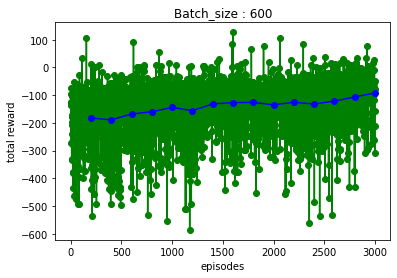

Streaming output truncated to the last 5000 lines.
Reward for episode 492: -235.22817491990605, loss : -2.5855755615234375
episode: 493/3000, step: 120, score: -42.71612874562118
Reward for episode 493: -42.71612874562118, loss : 1.0102288818359375
episode: 494/3000, step: 133, score: -294.0107745689006
Reward for episode 494: -294.0107745689006, loss : -4.101763610839844
episode: 495/3000, step: 125, score: -374.32179831146414
Reward for episode 495: -374.32179831146414, loss : -4.17092529296875
episode: 496/3000, step: 101, score: -224.79379091697166
Reward for episode 496: -224.79379091697166, loss : -5.321600341796875
episode: 497/3000, step: 105, score: -200.83145342358267
Reward for episode 497: -200.83145342358267, loss : -3.3252587890625
episode: 498/3000, step: 133, score: -299.00230797005776
Reward for episode 498: -299.00230797005776, loss : -0.8084630584716797
episode: 499/3000, step: 113, score: -289.2350123682313
Reward for episode 499: -289.2350123682313, loss : -6.54109

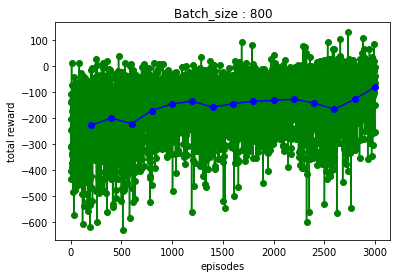

In [16]:
for m in [100, 300, 600, 800]:
  agent4 = Network(env4, "LunarLander-v2", batch_size = m)
  rewards_array, k_episode_score, points, loss_array = agent4.train(3000)
  plt.plot(range(len(rewards_array)), rewards_array, '-go')
  plt.plot(points, k_episode_score, '-bo')
  plt.title("Batch_size : {}".format(m))
  plt.xlabel('episodes')
  plt.ylabel('total reward')
  plt.show()

increasing the batchsize in LunarLander problem, we can see that the average reward over the episode interval between 0 to 3000 is decreasing. The average reward in batchsize = 800 at episode 3000 is less than that of batchsize = 100 for episode 3000
#### Running CartPole on different batchsizes

Streaming output truncated to the last 5000 lines.
episode: 458/3000, step: 40, score: 41.0
Reward for episode 458: 41.0, loss : 5.204276123046875
episode: 459/3000, step: 13, score: 14.0
Reward for episode 459: 14.0, loss : 0.947405014038086
episode: 460/3000, step: 19, score: 20.0
Reward for episode 460: 20.0, loss : 1.7765165710449218
episode: 461/3000, step: 9, score: 10.0
Reward for episode 461: 10.0, loss : 0.5185816192626953
episode: 462/3000, step: 14, score: 15.0
Reward for episode 462: 15.0, loss : 1.0768640899658204
episode: 463/3000, step: 11, score: 12.0
Reward for episode 463: 12.0, loss : 0.7577590942382812
episode: 464/3000, step: 43, score: 44.0
Reward for episode 464: 44.0, loss : 5.33806640625
episode: 465/3000, step: 19, score: 20.0
Reward for episode 465: 20.0, loss : 1.7206228637695313
episode: 466/3000, step: 18, score: 19.0
Reward for episode 466: 19.0, loss : 1.6279464721679688
episode: 467/3000, step: 15, score: 16.0
Reward for episode 467: 16.0, loss : 1.2892

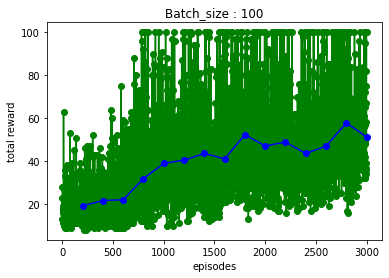

Streaming output truncated to the last 5000 lines.
episode: 501/3000, step: 17, score: 18.0
Reward for episode 501: 18.0, loss : 0.48388890584309896
episode: 502/3000, step: 49, score: 50.0
Reward for episode 502: 50.0, loss : 2.0827392578125
episode: 503/3000, step: 20, score: 21.0
Reward for episode 503: 21.0, loss : 0.6439127604166667
episode: 504/3000, step: 31, score: 32.0
Reward for episode 504: 32.0, loss : 1.0996766153971353
episode: 505/3000, step: 73, score: 74.0
Reward for episode 505: 74.0, loss : 3.086170654296875
episode: 506/3000, step: 18, score: 19.0
Reward for episode 506: 19.0, loss : 0.5587877400716146
episode: 507/3000, step: 22, score: 23.0
Reward for episode 507: 23.0, loss : 0.7454424540201823
episode: 508/3000, step: 20, score: 21.0
Reward for episode 508: 21.0, loss : 0.5819165547688802
episode: 509/3000, step: 21, score: 22.0
Reward for episode 509: 22.0, loss : 0.63131591796875
episode: 510/3000, step: 35, score: 36.0
Reward for episode 510: 36.0, loss : 1.2

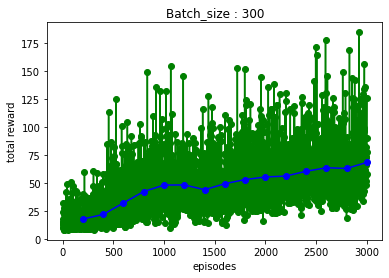

Streaming output truncated to the last 5000 lines.
episode: 501/3000, step: 81, score: 82.0
Reward for episode 501: 82.0, loss : 1.69783935546875
episode: 502/3000, step: 38, score: 39.0
Reward for episode 502: 39.0, loss : 0.7088541666666667
episode: 503/3000, step: 42, score: 43.0
Reward for episode 503: 43.0, loss : 0.7855570983886718
episode: 504/3000, step: 32, score: 33.0
Reward for episode 504: 33.0, loss : 0.5892848714192709
episode: 505/3000, step: 45, score: 46.0
Reward for episode 505: 46.0, loss : 0.8675153605143229
episode: 506/3000, step: 77, score: 78.0
Reward for episode 506: 78.0, loss : 1.6538240559895834
episode: 507/3000, step: 52, score: 53.0
Reward for episode 507: 53.0, loss : 1.0412941487630207
episode: 508/3000, step: 26, score: 27.0
Reward for episode 508: 27.0, loss : 0.43459828694661456
episode: 509/3000, step: 37, score: 38.0
Reward for episode 509: 38.0, loss : 0.7273174031575521
episode: 510/3000, step: 27, score: 28.0
Reward for episode 510: 28.0, loss :

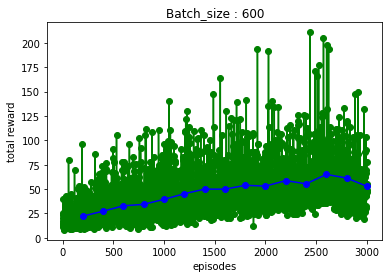

Streaming output truncated to the last 5000 lines.
episode: 501/3000, step: 36, score: 37.0
Reward for episode 501: 37.0, loss : 0.5338440704345703
episode: 502/3000, step: 51, score: 52.0
Reward for episode 502: 52.0, loss : 0.768809814453125
episode: 503/3000, step: 21, score: 22.0
Reward for episode 503: 22.0, loss : 0.22662508010864257
episode: 504/3000, step: 62, score: 63.0
Reward for episode 504: 63.0, loss : 0.9043278503417969
episode: 505/3000, step: 22, score: 23.0
Reward for episode 505: 23.0, loss : 0.23842281341552735
episode: 506/3000, step: 46, score: 47.0
Reward for episode 506: 47.0, loss : 0.6381416702270508
episode: 507/3000, step: 33, score: 34.0
Reward for episode 507: 34.0, loss : 0.39918411254882813
episode: 508/3000, step: 34, score: 35.0
Reward for episode 508: 35.0, loss : 0.43561080932617186
episode: 509/3000, step: 48, score: 49.0
Reward for episode 509: 49.0, loss : 0.69462890625
episode: 510/3000, step: 89, score: 90.0
Reward for episode 510: 90.0, loss : 

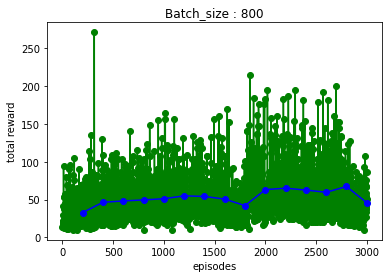

In [17]:
for m in [100, 300, 600, 800]:
  agent3 = Network(env3, "CartPole-v1", batch_size = m)
  rewards_array, k_episode_score, points, loss_array = agent3.train(3000)
  plt.plot(range(len(rewards_array)), rewards_array, '-go')
  plt.plot(points, k_episode_score, '-bo')
  plt.title("Batch_size : {}".format(m))
  plt.xlabel('episodes')
  plt.ylabel('total reward')
  plt.show()

Similar to LunarLander problem, increasing the batchsize in Cartpole problem, we can see that the average reward over the episode interval between 0 to 3000 is decreasing. The average reward in batchsize = 800 at episode 3000 is less than that of batchsize = 100 for episode 3000